In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
import warnings

In [273]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [274]:
cd C:\Users\Iulia\Desktop\CreditRisk

C:\Users\Iulia\Desktop\CreditRisk


In [275]:
data = pd.read_csv('DTSE_AIS_unemployment_task_data.csv')

In [276]:
data['Period'] = pd.to_datetime(data['Period'])
data.set_index('Period', inplace=True)

In [277]:
# calculate the percentage of missing values in each column
# missing_percentages = df.isna().mean() * 100
missing_percentages = data.isin([np.nan]).mean() * 100
# sort the columns by percentage of missing values, descending
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
# select the top columns with missing values (adjust the number as needed)
top_missing_percentages = round(sorted_missing_percentages,4).head(15)
# print the top columns with their percentage of missing values
print(top_missing_percentages)

data.interpolate(method='linear', inplace=True)

unemp      0.4926
realgdp    0.0000
pop        0.0000
infl       0.0000
dtype: float64


In [278]:
from scipy.stats.mstats import winsorize

# Specify the variables to winsorize
variables_to_winsorize = ['unemp', 'realgdp', 'pop', 'infl']  # Add other variables as needed

# Apply winsorization to each variable
for variable in variables_to_winsorize:
    data[variable] = winsorize(data[variable], limits=[0.05, 0.05])

In [281]:
from statsmodels.tsa.stattools import grangercausalitytests

variables=data.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(data[[row, col]], maxlag=20, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]
print(matrix)

           realgdp_x   pop_x  unemp_x
realgdp_y        1.0  0.0006   0.1060
pop_y            0.0  1.0000   0.2114
unemp_y          0.0  0.1051   1.0000


In [280]:
data = data.drop(['infl'],axis=1)

In [282]:
# Augmented Dickey-Fuller Test for Stationarity
for variable in data.columns:
    result = adfuller(data[variable])
    print(f'Variable: {variable}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    is_stationary = result[1] <= 0.05
    print(f'Stationary: {is_stationary}')
    print('-' * 40)

Variable: realgdp
ADF Statistic: 1.5602144788931356
p-value: 0.9977331685393906
Critical Values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612
Stationary: False
----------------------------------------
Variable: pop
ADF Statistic: -1.363031298843511
p-value: 0.5998655313094023
Critical Values:
   1%: -3.464337030867007
   5%: -2.876478799035722
   10%: -2.574733103221565
Stationary: False
----------------------------------------
Variable: unemp
ADF Statistic: -2.4627491723568506
p-value: 0.12480287353208053
Critical Values:
   1%: -3.4633090972761744
   5%: -2.876029332045744
   10%: -2.5744932593252643
Stationary: False
----------------------------------------


In [242]:
# # Define a function to check stationarity using ADF test
# def check_stationarity(series):
#     result = adfuller(series)
#     return result[1] <= 0.05  # Returns True if stationary

# # Define the maximum number of differencing attempts
# max_differencing_attempts = 3  # You can adjust this as needed

# # Iterate through columns and perform differencing until stationary
# for variable in data.columns:
#     print(f'Variable: {variable}')
    
#     differencing_attempts = 0
#     is_stationary = check_stationarity(data[variable])
    
#     while not is_stationary and differencing_attempts < max_differencing_attempts:
#         data[variable] = data[variable].diff()
#         data.dropna(inplace=True)  # Drop missing values
        
#         differencing_attempts += 1
#         is_stationary = check_stationarity(data[variable])
    
#     if is_stationary:
#         print(f'Stationary after {differencing_attempts} differencing attempt(s)')
#     else:
#         print(f'Variable remains non-stationary after {differencing_attempts} differencing attempt(s)')

# # The 'data' DataFrame now contains differenced variables (some may still be non-stationary)


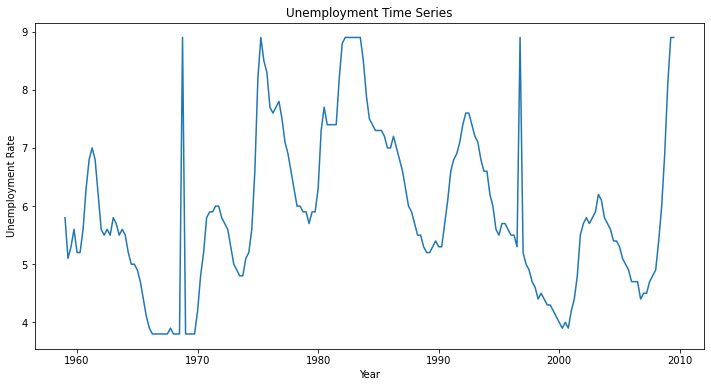

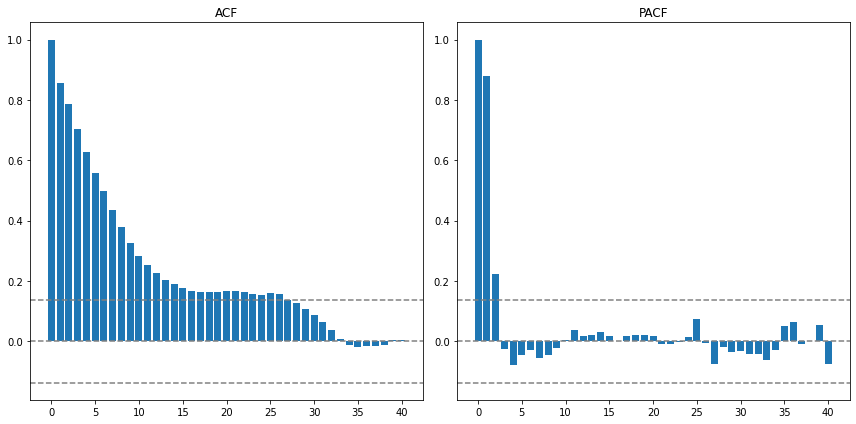

In [243]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['unemp'])
plt.title('Unemployment Time Series')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.show()

# Calculate ACF and PACF
lag_acf = acf(data['unemp'], nlags=40)
lag_pacf = pacf(data['unemp'], nlags=40, method='ols')

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.bar(range(len(lag_acf)), lag_acf)
plt.title('ACF')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')

plt.subplot(122)
plt.bar(range(len(lag_pacf)), lag_pacf)
plt.title('PACF')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['unemp'])), linestyle='--', color='gray')

plt.tight_layout()
plt.show()

# Differencing to make the series stationary (if necessary)
# data['diff_unemp'] = diff(data['unemp'], k_diff=1)

C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Iulia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


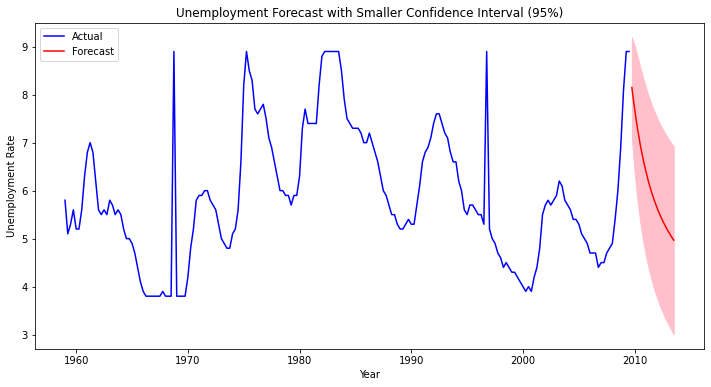

In [244]:
from statsmodels.tsa.statespace.varmax import VARMAX

# Specify the variables you want to include in the model
variables = ['unemp', 'realgdp', 'pop']  # Add other variables as needed

# Train the VARMAX model with multiple variables
model = VARMAX(data[variables], order=(1, 1))
results_varmax = model.fit(disp=False)

# Forecast future unemployment values along with other variables
forecast_start = data.index[-1] + pd.DateOffset(months=3)
forecast_end = pd.to_datetime('2013-10-01')
forecast_steps = (forecast_end - forecast_start).days // 90
# Forecast future unemployment values along with other variables with a smaller confidence interval (e.g., 90%)
forecast_results = results_varmax.get_forecast(steps=forecast_steps, alpha=0.05)

# Extract the forecasted values for 'unemp'
forecast_unemp = forecast_results.predicted_mean['unemp']

# Plot the original data and the forecast for 'unemp' with the smaller confidence interval
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['unemp'], label='Actual', color='blue')
plt.plot(forecast_results.predicted_mean.index, forecast_unemp, label='Forecast', color='red')
forecast_ci = forecast_results.conf_int(alpha=0.1)  # Specify the alpha for the confidence interval
plt.fill_between(forecast_results.predicted_mean.index, forecast_ci['lower unemp'], forecast_ci['upper unemp'], color='pink')
plt.title('Unemployment Forecast with Smaller Confidence Interval (95%)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

### SARIMAX

In [283]:
# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    return result[1] <= 0.05

# Differencing
data['unemp'] = data['unemp'].diff().dropna()
data.interpolate(method='linear', inplace=True)
# Backfill any remaining missing values
data['unemp'] = data['unemp'].fillna(method='backfill')

# Check stationarity
is_stationary = check_stationarity(data['unemp'])
print(f'Is Stationary: {is_stationary}')

Is Stationary: True


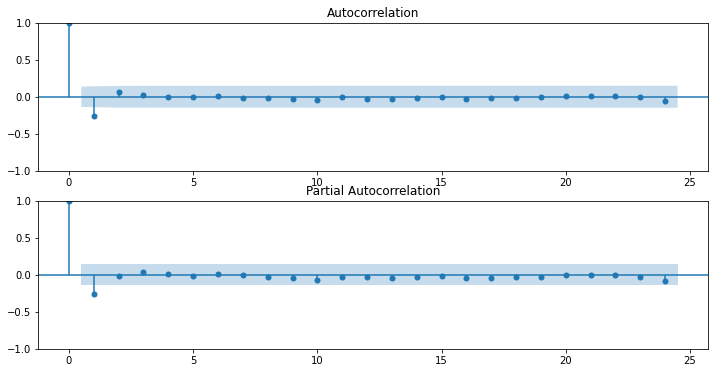

In [284]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['unemp'], ax=plt.gca())
plt.subplot(212)
plot_pacf(data['unemp'], ax=plt.gca())
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define parameter ranges
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]
s = 4  # Seasonal frequency (quarterly data)

# Perform grid search for best SARIMA model
best_aic = float("inf")
best_params = None

for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(data['unemp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = (p, d, q, P, D, Q)
    except:
        continue

print(f'Best SARIMA Model: SARIMA{best_params} with AIC={best_aic}')

In [ ]:
# p = 1
# d = 1
# q = 1
# s = 4  # Seasonal order

# model_sarima = SARIMAX(train_data['unemp'], order=(p, d, q), seasonal_order=(P, D, Q, s))
# results_sarima = model_sarima.fit()

best_model = SARIMAX(data['unemp'], order=(best_params[0], best_params[1], best_params[2]),
                     seasonal_order=(best_params[3], best_params[4], best_params[5], s))
results_sarimax = best_model.fit()

# Display model summary
print(results_sarimax.summary())

In [ ]:
forecast_start = data.index[-1] + pd.DateOffset(months=3)
forecast_end = pd.to_datetime('2013-10-01')
forecast_steps = (forecast_end - forecast_start).days // 90
forecast = results_sarimax.get_forecast(steps=forecast_steps)

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['unemp'], label='Actual')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
forecast_ci = forecast.conf_int()

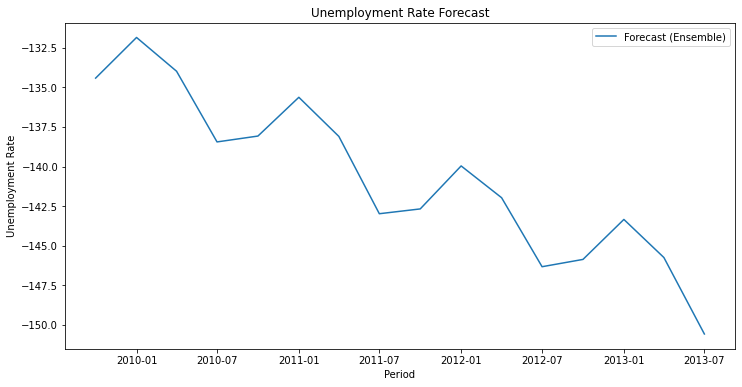

In [270]:
forecast_period = pd.date_range(start='2009-10-01', end='2013-10-01', freq='Q')
# Ensemble Forecasting (corrected)
forecast_varmax = results_varmax.get_forecast(steps=len(forecast_period))
forecast_varmax_mean = forecast_varmax.predicted_mean.unemp

forecast_sarima = results_sarimax.get_forecast(steps=len(forecast_period))
forecast_sarima_mean = forecast_sarima.predicted_mean

weight_varmax = 0.5  # Adjust the weights as needed
weight_sarima = 0.5
final_forecast = weight_varmax * forecast_varmax_mean + weight_sarima * forecast_sarima_mean

# Create a DataFrame with the correct index
forecast_df = pd.DataFrame(final_forecast, index=final_forecast.index, columns=['unemp_forecast'])

# Visualize the Forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['unemp_forecast'], label='Forecast (Ensemble)')
plt.legend()
plt.title('Unemployment Rate Forecast')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.show()

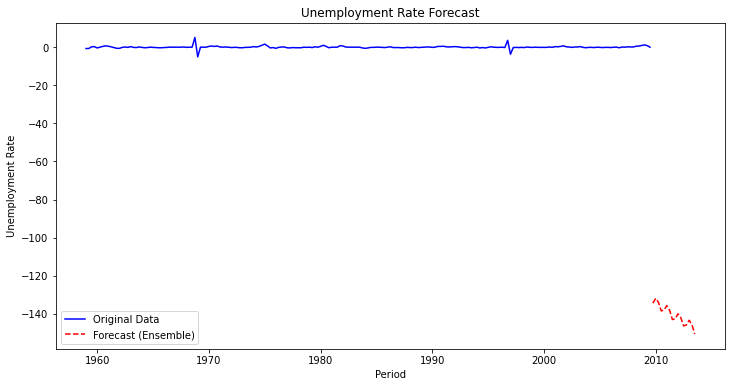

In [271]:
# Create a DataFrame with the correct index for data
data_index = data.index

# Visualize the Forecast alongside the original data
plt.figure(figsize=(12, 6))
plt.plot(data_index, data['unemp'], label='Original Data', color='blue')
plt.plot(forecast_df.index, forecast_df['unemp_forecast'], label='Forecast (Ensemble)', linestyle='--', color='red')
plt.legend()
plt.title('Unemployment Rate Forecast')
plt.xlabel('Period')
plt.ylabel('Unemployment Rate')
plt.show()